In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from pathlib import Path

In [2]:

bhs = pd.read_csv("../../data/full/blackholes_gaia_clean.csv").assign(label=0)
stars = pd.read_csv("../../data/full/stars_gaia_clean.csv").assign(label=1)

features = [
    "parallax", "pmra", "pmdec", "phot_g_mean_mag",
    "bp_rp",]
# balanced subset
bhs_count = len(bhs)
stars_bal = stars.sample(n=bhs_count, random_state=42)
df = pd.concat([stars_bal, bhs], ignore_index=True)

X = df[features]
y = df["label"]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
logreg.fit(X_train, y_train)
print("LogReg\n", classification_report(y_test, logreg.predict(X_test), target_names=["star","blackhole"]))

rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
rf.fit(X_train, y_train)
print("RF\n", classification_report(y_test, rf.predict(X_test), target_names=["star","blackhole"]))

LogReg
               precision    recall  f1-score   support

        star       0.90      0.92      0.91       400
   blackhole       0.92      0.90      0.91       400

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

RF
               precision    recall  f1-score   support

        star       0.95      0.96      0.96       400
   blackhole       0.96      0.95      0.95       400

    accuracy                           0.95       800
   macro avg       0.96      0.95      0.95       800
weighted avg       0.96      0.95      0.95       800



In [3]:
#features 
features = [
    "parallax", "pmra", "pmdec", "phot_g_mean_mag", "bp_rp",]

# for stars vs blackholes (bhs = 2000 rows)
sizes = [1000, 2000, 4000]

def eval_size_bh(n_total, n_splits=50):
    n_per = min(n_total // 2, len(bhs), len(stars))

    stars_sub = stars.sample(n=n_per, random_state=42)
    bhs_sub = bhs.sample(n=n_per, random_state=42)

    df = pd.concat([stars_sub, bhs_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
    for train_idx, test_idx in splitter.split(X, y):
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])
        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(y[test_idx], y_pred, average="binary", zero_division=0)
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s)
    }

for n in sizes:
    print(eval_size_bh(n))
    
    

{'size': 1000, 'acc_mean': np.float64(0.9324999999999999), 'prec_mean': np.float64(0.9441654806705517), 'rec_mean': np.float64(0.9202000000000001), 'f1_mean': np.float64(0.9316373658067161)}
{'size': 2000, 'acc_mean': np.float64(0.92665), 'prec_mean': np.float64(0.9394800162860499), 'rec_mean': np.float64(0.9125999999999999), 'f1_mean': np.float64(0.9255457240123675)}
{'size': 4000, 'acc_mean': np.float64(0.9230000000000002), 'prec_mean': np.float64(0.9342759718958047), 'rec_mean': np.float64(0.9102), 'f1_mean': np.float64(0.9219889464900308)}


##Increased the n_splits to 100 using RandomForest 

In [4]:


def eval_size_rf(n_total, n_splits=50):
    n_per = min(n_total // 2, len(bhs), len(stars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    bhs_sub   = bhs.sample(n=n_per, random_state=42)
    df = pd.concat([stars_sub, bhs_sub], ignore_index=True)

    X = df[features].values
    y = df["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    accs = []; precs = []; recs = []; f1s = []

    for train_idx, test_idx in splitter.split(X, y):
        clf = RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            class_weight="balanced_subsample"
        )
        clf.fit(X[train_idx], y[train_idx])
        y_pred = clf.predict(X[test_idx])

        accs.append(accuracy_score(y[test_idx], y_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y[test_idx], y_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s),
    }

for n in sizes:
    print("RF", eval_size_rf(n, n_splits=50))


RF {'size': 1000, 'acc_mean': np.float64(0.9486), 'prec_mean': np.float64(0.9453625672979581), 'rec_mean': np.float64(0.9526), 'f1_mean': np.float64(0.9488120660930771)}
RF {'size': 2000, 'acc_mean': np.float64(0.9519), 'prec_mean': np.float64(0.9550605302239767), 'rec_mean': np.float64(0.9487000000000001), 'f1_mean': np.float64(0.9517236909698852)}
RF {'size': 4000, 'acc_mean': np.float64(0.953525), 'prec_mean': np.float64(0.9601307431549396), 'rec_mean': np.float64(0.94645), 'f1_mean': np.float64(0.9531900830444933)}


##Plotting results for Accuracy, Precicion, Recall, F1 Score 


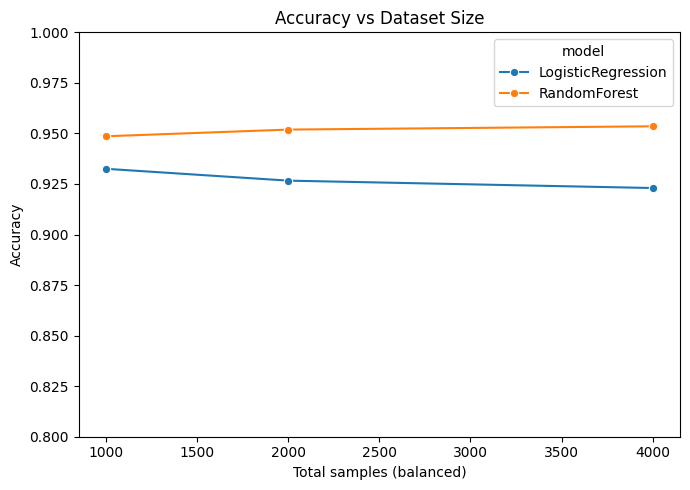

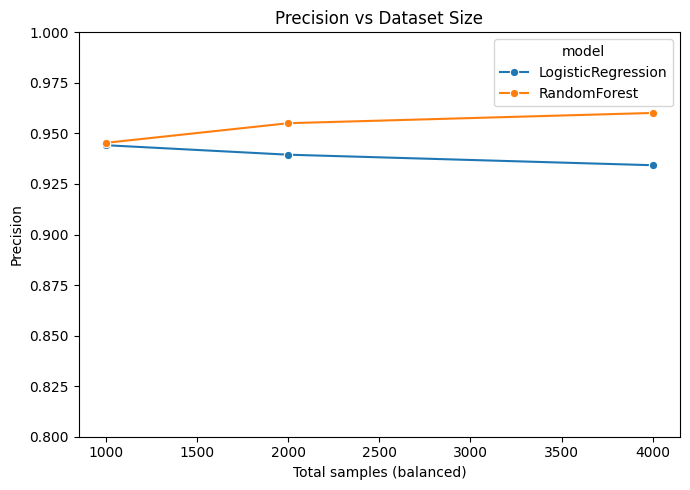

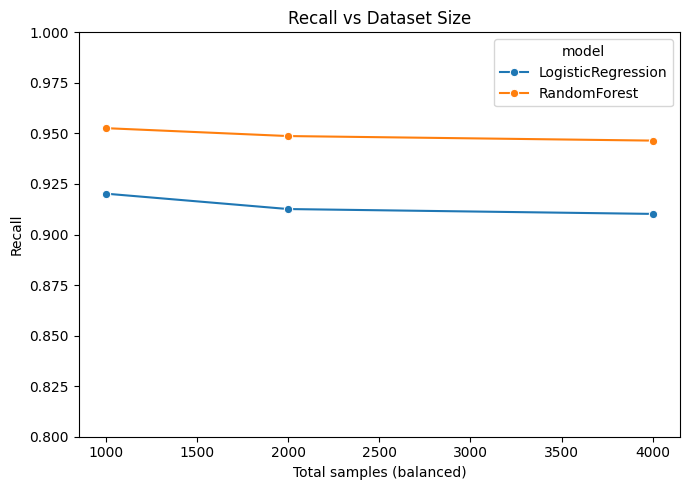

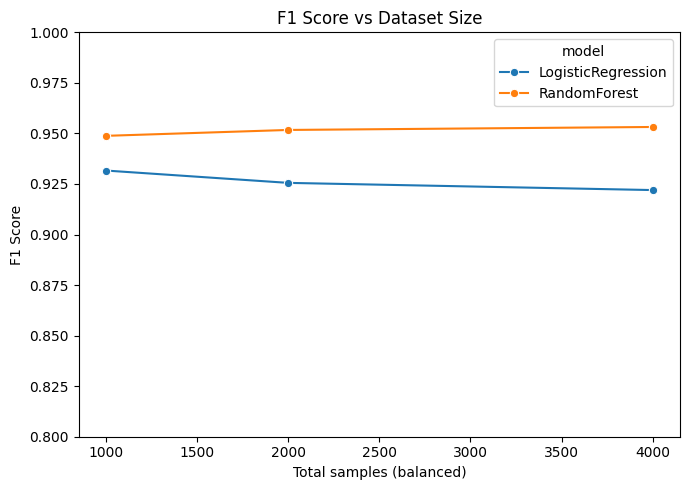

In [5]:
logreg_results = [eval_size_bh(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]

df_log = pd.DataFrame(logreg_results)
df_log["model"] = "LogisticRegression"

df_rf = pd.DataFrame(rf_results)
df_rf["model"] = "RandomForest"

df_plot = pd.concat([df_log, df_rf], ignore_index=True)

plot_dir = Path("../../Main_plots/binary_blackholes_vs_stars")
plot_dir.mkdir(parents=True, exist_ok=True)

metrics = ["acc_mean", "prec_mean", "rec_mean", "f1_mean"]
titles = {
    "acc_mean": "Accuracy",
    "prec_mean": "Precision",
    "rec_mean": "Recall",
    "f1_mean": "F1 Score",
}

for m in metrics:
    plt.figure(figsize=(7,5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles[m])
    plt.ylim(0.8, 1.0)  # adjust if needed
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()